In [1]:
import os
import sys
sys.path.append( os.path.abspath("../../workspace/python-work/python 3/cs230_deeplearning_implement/ec_code/")  )
from class2.week3.assignment3.tf_utils import load_dataset, random_mini_batches, convert_to_one_hot, predict
import time
import math
import numpy as np
import h5py
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.python.framework import ops
"""
学习TensorFlow这个框架：
    初始化变量
    建立一个会话
    训练的算法
    实现一个神经网络
    使用框架编程不仅可以节省你的写代码时间，还可以让你的优化速度更快。
"""

%matplotlib inline
np.random.seed(1)



In [2]:
#计算损失的公式： 
# loss=L(y^,y)=(y^(i)−y(i))**2
y_hat = tf.constant(36,name="y_hat")
y=tf.constant(39,name="y")

loss=tf.Variable( (y-y_hat)**2,name="loss")

# When init is run later (session.run(init))
# the loss variable will be initialized and ready to be computed
init=tf.global_variables_initializer()

with tf.Session() as session:
    #print(type(session)) #<class 'tensorflow.python.client.session.Session'>
    session.run(init)
    #print(type(init))    #<class 'tensorflow.python.framework.ops.Operation'>
    print(session.run(loss)) 
    #print(type(loss))    #<class 'tensorflow.python.ops.variables.RefVariable'>
    

# 对于Tensorflow的代码实现而言，实现代码的结构如下：
#     创建Tensorflow变量（此时，尚未直接计算）
#     实现Tensorflow变量之间的操作定义
#     初始化Tensorflow变量
#     创建Session
#     运行Session，此时，之前编写操作都会在这一步运行。
# 
# 因此，当我们为损失函数创建一个变量时，我们简单地将损失定义为其他数量的函数，
# 但没有评估它的价值。 为了评估它，我们需要运行init=tf.global_variables_initializer()，
# 初始化损失变量，在最后一行，我们最后能够评估损失的值并打印它的值。



Instructions for updating:
Colocations handled automatically by placer.


9


In [19]:
a=tf.constant(2)
b=tf.constant(134)
c=tf.multiply(a,b)
print(type(a),a)
print(type(c),c)
#并没有看到结果248，不过我们得到了一个Tensor类型的变量，没有维度，数字类型为int32。
# 之前所做的一切都只是把这些东西放到了一个“计算图(computation graph)”中，
# 而还没有开始运行这个计算图，为了实际计算这两个数字，需要创建一个会话并运行它

print( tf.Session().run(c)  )
 

<class 'tensorflow.python.framework.ops.Tensor'> Tensor("Const_2:0", shape=(), dtype=int32)
<class 'tensorflow.python.framework.ops.Tensor'> Tensor("Mul_9:0", shape=(), dtype=int32)
268


In [18]:
#placeholders占位符是一个对象，它的值只能在稍后指定，
# 要指定占位符的值，可以使用一个feed字典（feed_dict变量）来传入
x=tf.placeholder(tf.int64)
print(type(x),x)
sess=tf.Session()
print(type(x))
print( sess.run(3*x,feed_dict={x:5} ))
sess.close()


<class 'tensorflow.python.framework.ops.Tensor'> Tensor("Placeholder_4:0", dtype=int64)
<class 'tensorflow.python.framework.ops.Tensor'>
15


In [17]:
#Y=WX+b
def linear_function():
    np.random.seed(1)
    X=np.random.randn(3,1)
    W=np.random.randn(4,3)
    b=np.random.randn(4,1)
    Y=tf.matmul(W,X)+b
    print(type(Y),Y)
    
    sess=tf.Session()
    reslut=sess.run(Y)
    print(reslut)
    sess.close()
    
linear_function()

<class 'tensorflow.python.framework.ops.Tensor'> Tensor("add_1:0", shape=(4, 1), dtype=float64)
[[-2.15657382]
 [ 2.95891446]
 [-1.08926781]
 [-0.84538042]]


In [27]:
def sigmoid(z):
    x=tf.placeholder(tf.float32)
    #sess = tf.Session()
    # result = sess.run(...,feed_dict = {...})
    # sess.close()
    with tf.Session() as sess:
        result=sess.run( tf.sigmoid(x),feed_dict={x:z})
        print(result)
        
sigmoid(0)
sigmoid(12)
    

0.5
0.9999938


Y = 1
number of training examples = 1080
number of test examples = 120
X_train shape: (12288, 1080)
Y_train shape: (6, 1080)
X_test shape: (12288, 120)
Y_test shape: (6, 120)


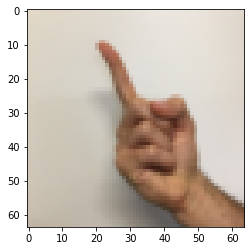

In [49]:
# Loading the dataset
X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

index = 11
plt.imshow(X_train_orig[index])
print("Y = " + str(np.squeeze(Y_train_orig[:,index])))


# Flatten the training and test images
X_train_flatten = X_train_orig.reshape(X_train_orig.shape[0], -1).T
X_test_flatten = X_test_orig.reshape(X_test_orig.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255
X_test = X_test_flatten/255

def ec_convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    # print(Y,Y.shape)
    return Y

# Convert training and test labels to one hot matrices
Y_train = ec_convert_to_one_hot(Y_train_orig, 6)
Y_test = ec_convert_to_one_hot(Y_test_orig, 6)




print ("number of training examples = " + str(X_train.shape[1]))
print ("number of test examples = " + str(X_test.shape[1]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))

In [61]:
# GRADED FUNCTION: create_placeholders
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """
    X=tf.placeholder(tf.float32,[n_x,None])
    Y=tf.placeholder(tf.float32,[n_y,None])
    return X, Y



# GRADED FUNCTION: initialize_parameters
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
    W1=tf.get_variable("W1",[25,12288],initializer=tf.contrib.layers.xavier_initializer(seed=1))
    b1=tf.get_variable("b1",[25,1],initializer=tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12, 25], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer = tf.zeros_initializer())
    W3 = tf.get_variable("W3", [6, 12], initializer = tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [6, 1], initializer = tf.zeros_initializer())
    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    return parameters
 #用于清除默认图形堆栈并重置全局默认图形。
 #这些参数只有物理空间，但是还没有被赋值，这是因为没有通过session执行。
tf.reset_default_graph()
with tf.Session() as sess:
    parameters = initialize_parameters()
    print("W1 = " + str(parameters["W1"]))
    print("b1 = " + str(parameters["b1"]))
    print("W2 = " + str(parameters["W2"]))
    print("b2 = " + str(parameters["b2"]))
    
    
    
    
# GRADED FUNCTION: forward_propagation
def forward_propagation(X, parameters):   
    #前向传播要在Z3处停止，因为在TensorFlow中最后的线性输出层的输出作为计算损失函数的输入，
    # 所以不需要A3.    softmax是   e**h(x)/sum(e**h(x))
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    Z1 = tf.add(tf.matmul(W1,X),b1)        # Z1 = np.dot(W1, X) + b1
    #Z1 = tf.matmul(W1,X) + b1             #也可以这样写
    A1 = tf.nn.relu(Z1)                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)     # Z3 = np.dot(W3,Z2) + b3
    return Z3



# GRADED FUNCTION: compute_cost 
def compute_cost(Z3, Y):
    """ 
    Returns:
    cost - Tensor of the cost function
    """
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)  #转置
    labels = tf.transpose(Y)   #转置
    #计算交叉熵成本
    cost=tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=logits,labels=labels))
    return cost

W1 = <tf.Variable 'W1:0' shape=(25, 12288) dtype=float32_ref>
b1 = <tf.Variable 'b1:0' shape=(25, 1) dtype=float32_ref>
W2 = <tf.Variable 'W2:0' shape=(12, 25) dtype=float32_ref>
b2 = <tf.Variable 'b2:0' shape=(12, 1) dtype=float32_ref>


In [64]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
    """ 
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m)=X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y=Y_train.shape[0]                            # n_y : output size
    costs=[]                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    X,Y=create_placeholders(n_x,n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X,parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3,Y)
    
    #===================important============================ 
    #===================important============================ 
    #===================important============================ 
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):
            epoch_cost = 0        # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:
                (minibatch_X, minibatch_Y) = minibatch
                # IMPORTANT: The line that runs the graph on a minibatch.
                #===================important============================ 
                #===================important============================ 
                #===================important============================ 
                #===================important============================ 
                #===================important============================ 
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                _ , minibatch_cost = sess.run([optimizer,cost],feed_dict={X:minibatch_X,Y:minibatch_Y})
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if epoch % 5 == 0:
                costs.append(epoch_cost)
                if print_cost and epoch % 100 == 0:
                        print("epoch = " + str(epoch) + "    epoch_cost = " + str(epoch_cost))

        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

epoch = 0    epoch_cost = 1.8557019125331533


epoch = 100    epoch_cost = 1.0164577274611502


epoch = 200    epoch_cost = 0.7331024182565286


epoch = 300    epoch_cost = 0.5729390003464437


epoch = 400    epoch_cost = 0.46877381024938647


epoch = 500    epoch_cost = 0.3810153188127459


epoch = 600    epoch_cost = 0.31382895419091894


epoch = 700    epoch_cost = 0.2541691507353927


epoch = 800    epoch_cost = 0.20380747521465473


epoch = 900    epoch_cost = 0.16642917895858936


epoch = 1000    epoch_cost = 0.14096821438182483


epoch = 1100    epoch_cost = 0.10759843445637012


epoch = 1200    epoch_cost = 0.08669052357700738


epoch = 1300    epoch_cost = 0.06101937958914223


epoch = 1400    epoch_cost = 0.05092194857019367


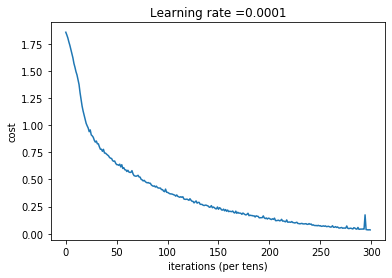

Parameters have been trained!


Train Accuracy: 0.9990741
Test Accuracy: 0.725
CPU Time = 451.8445223 s


In [65]:
#开始时间
start_time = time.clock()
#开始训练
parameters = model(X_train, Y_train, X_test, Y_test)
#结束时间
end_time = time.clock()
#计算时差
print("CPU Time = " + str(end_time - start_time) + " s" )
